# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
### Kamil Górski


---
## Step 0: Load The Data

First, let's load sample data to train the neural network using pickle. The train, validation and test set are in the separate files.


In [13]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [14]:
n_train = len(train['features'])
n_validation = len(valid['features'])
n_test = len(test['features'])
image_shape = X_train[0].shape
n_classes = len(list(set(train['labels'])))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Below, you can see an example of 20 traffic signs from the train set.

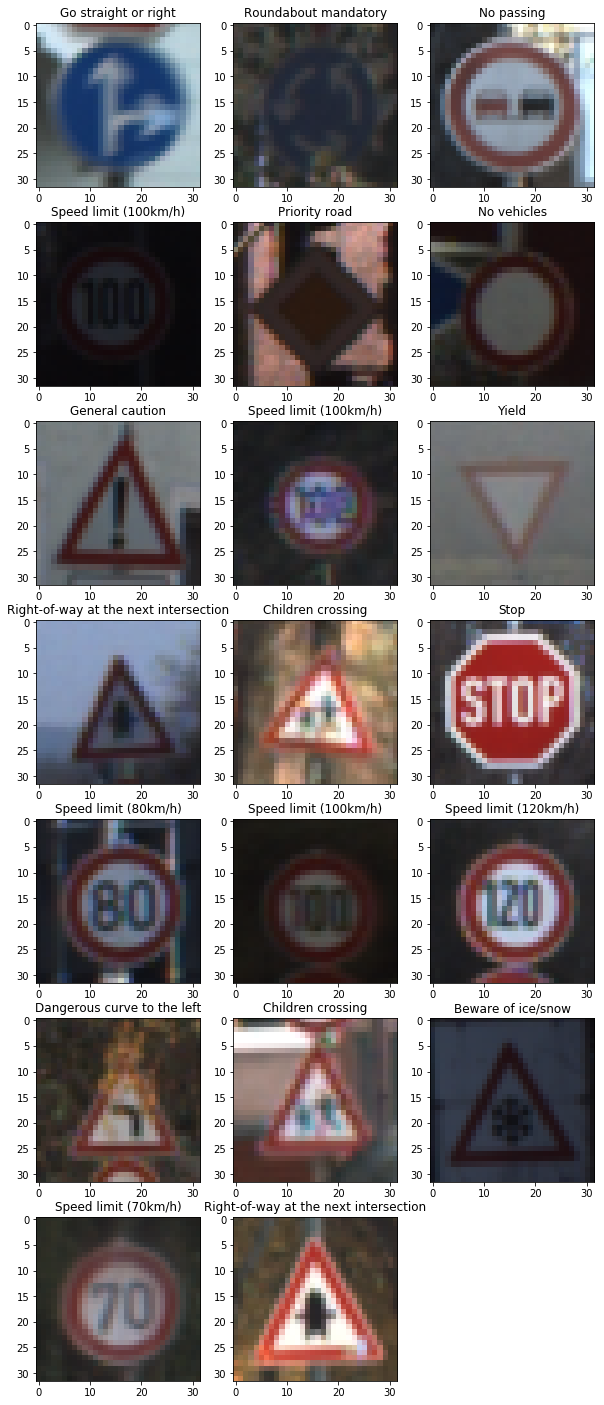

In [15]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as image
import csv
import random
import numpy as np

# Visualizations will be shown in the notebook.
%matplotlib inline

sign_dict = {}
with open('signnames.csv', 'r') as csvfile:
    next(csvfile)
    rd = csv.reader(csvfile)
    for row in rd:
        sign_dict[int(row[0])] = row[1]
              
def show_random_signs(plots, sset, match):
    fig = plt.figure(figsize=(10, 36))
    for img in range(plots):  
        a=fig.add_subplot(plots/2, 3, img+1)
        index = random.randint(0, len(sset))
        image = sset[index].squeeze()
        plt.imshow(image)
        a.set_title(sign_dict[match[index]])

    plt.show()

show_random_signs(20, X_train, y_train)

Another plot is rather interesting, total numer of signs of each type.

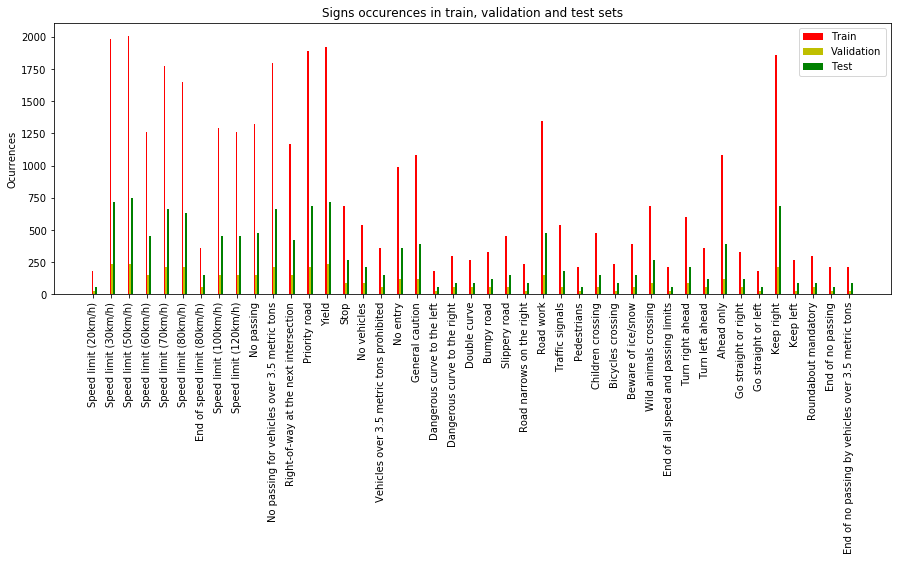

In [16]:
idx, cnt = np.unique(y_train, return_counts=True)
idx2, cnt2 = np.unique(y_valid, return_counts=True)
idx3, cnt3 = np.unique(y_test, return_counts=True)

signs = [sign_dict[x] for x in idx]

ind = np.arange(len(idx))  # the x locations for the groups
width = 0.1      # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(ind, cnt, width, color='r')
rects2 = ax.bar(ind + width, cnt2, width, color='y')
rects3 = ax.bar(ind + width * 2, cnt3, width, color='g')

ax.set_ylabel('Ocurrences')
ax.set_title('Signs occurences in train, validation and test sets')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(signs, rotation=90)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Train', 'Validation', 'Test'))

plt.show()

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

To preprocess images the `enhance_images` function was created. Equalization of the images has three steps:
 * color conversion (RGB to YUV)
 * grayscale convertion
 * normalization
his approach gave the beste efects during the tests. This three overtures gave me the best results in tests.

Filtered images are presented below.

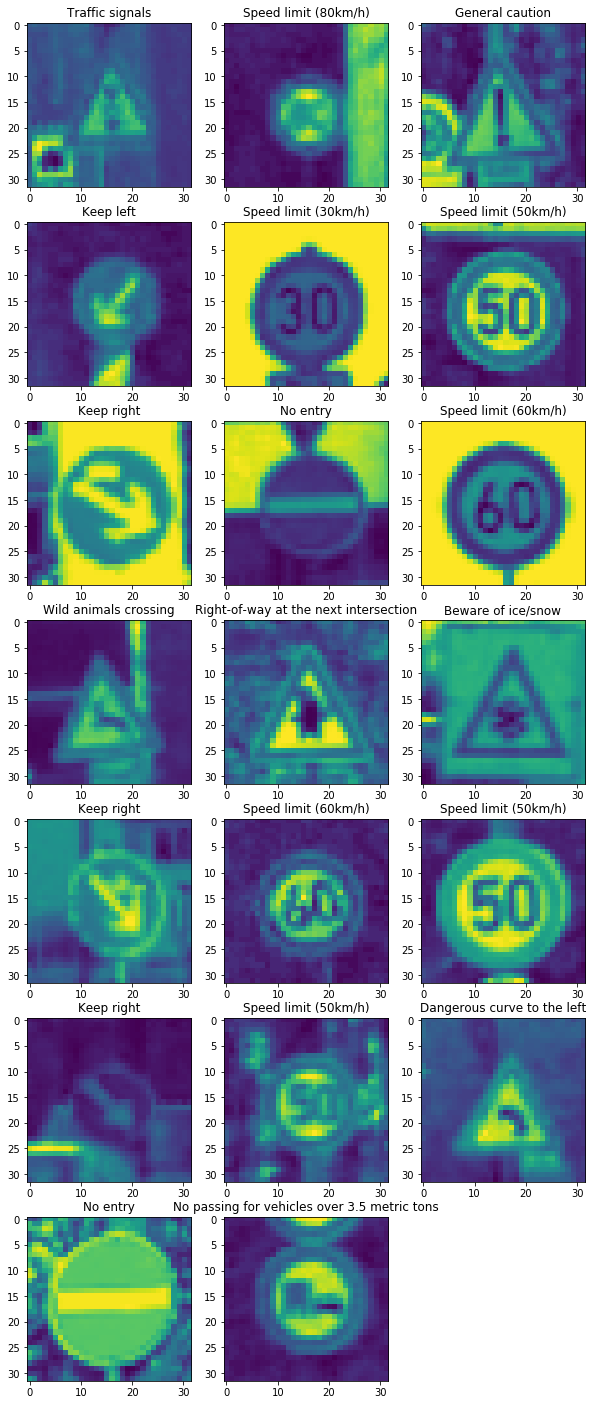

In [17]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import numpy as np
import cv2

def enhance_images(arr):
#     arr = np.mean(arr, axis=-1, keepdims=True)
#     return (arr - 128) / 255
    Xn = []
    for im in arr:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
        im = np.mean(im, axis=-1, keepdims=True)
        im = (im - 128) / 255
        Xn.append(im)
    return Xn


X_train = enhance_images(X_train)
X_valid = enhance_images(X_valid)
X_test = enhance_images(X_test)

show_random_signs(20, X_train, y_train)

### Model Architecture

The base of this solution was LeNet function from previous listings. I modified the architecture to obtain the best validation results as I could. The neural network now consists of following steps:

 * Convolutional. Input = 32x32x1. Output = 28x28x6.
     * large depth was used to learn a lot of characterisic attributes (such as shape, colours, etc) 
     * standard stride was used to move the filter window of size 5x5 every 1 pixel each side
     * it extracts image features
 * Relu activation.
     * relu was chosen to increase non-linearity of the network
 * Convolutional. Input = 28x28x6. Output = 10x10x16.
 * Relu activation.
 * Pooling. Input = 10x10x16. Output = 5x5x16.
     * used to downsample image, lowers up the detail number and parameters number
 * Flatten. Input = 11x11x16. Output = 400.
     * in order to pass the data to fully connected layer we mast flatten the data
 * Fully Connected. Input = 400. Output = 120.
     * after convolutional and pooling later we can reason the network
 * Relu activation.
 * Fully Connected. Input = 120. Output = 84.
 * Relu activation.
 * Fully Connected. Input = 84. Output = 43.
     * three connected layers with relu are used instead of one to keep the non-linearity of the network 

In [18]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(x):
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(6, 6, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 11x11x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1936, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

After some tests the rate and epoch amout were tuned. As I discovered the model is well-trained around 10 epochs. I left it on 20 level due to some unique shuffled cases. Test accuracy is very similar to validation accuracy.

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.0008
EPOCHS = 20
BATCH_SIZE = 128

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.839

EPOCH 2 ...
Validation Accuracy = 0.891

EPOCH 3 ...
Validation Accuracy = 0.893

EPOCH 4 ...
Validation Accuracy = 0.914

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 6 ...
Validation Accuracy = 0.915

EPOCH 7 ...
Validation Accuracy = 0.922

EPOCH 8 ...
Validation Accuracy = 0.934

EPOCH 9 ...
Validation Accuracy = 0.925

EPOCH 10 ...
Validation Accuracy = 0.924

EPOCH 11 ...
Validation Accuracy = 0.945

EPOCH 12 ...
Validation Accuracy = 0.946

EPOCH 13 ...
Validation Accuracy = 0.932

EPOCH 14 ...
Validation Accuracy = 0.943

EPOCH 15 ...
Validation Accuracy = 0.937

EPOCH 16 ...
Validation Accuracy = 0.936

EPOCH 17 ...
Validation Accuracy = 0.951

EPOCH 18 ...
Validation Accuracy = 0.948

EPOCH 19 ...
Validation Accuracy = 0.941

EPOCH 20 ...
Validation Accuracy = 0.944

Test Accuracy = 0.925
Model saved


---

## Step 3: Test a Model on New Images

I downloaded a 7 different German Signs from Google Street View to test the model. I converted them manually to 32x32 size. You can see them below: before and after filtering. I also mapped them by hand to correct indices from `.csv` file.

### Load and Output the Images

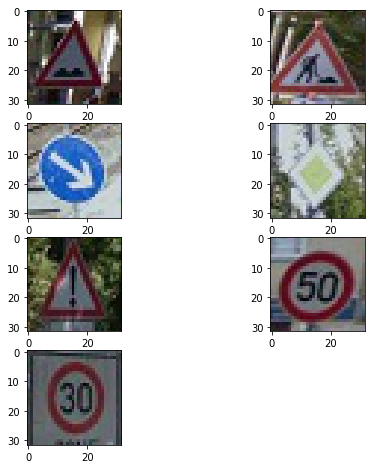

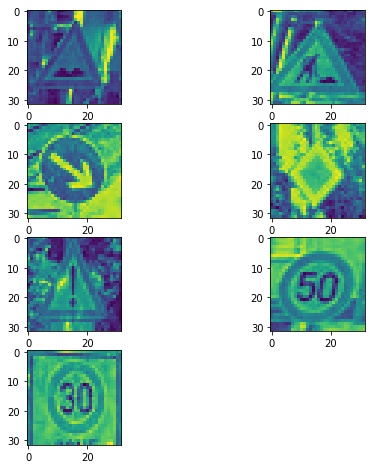

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
        
def show_signs(signs):
    fig = plt.figure(figsize=(8, 8))
    plots = len(signs)
    for img in range(plots):  
        a=fig.add_subplot(np.ceil(plots/2), 2, img+1)
        image = signs[img].squeeze()
        plt.imshow(image)
    plt.show()

X_custom = []

for i in range(1,8):
    X_custom.append(mpimg.imread('german/{}.jpg'.format(i)))
    
show_signs(X_custom)   
X_custom = enhance_images(X_custom)
show_signs(X_custom)

y_custom = [22, 25, 38, 12, 18, 2, 1]

### Predict the Sign Type for Each Image

The custom signs were tested against the neural network. One of them wasn't recognized correctly.

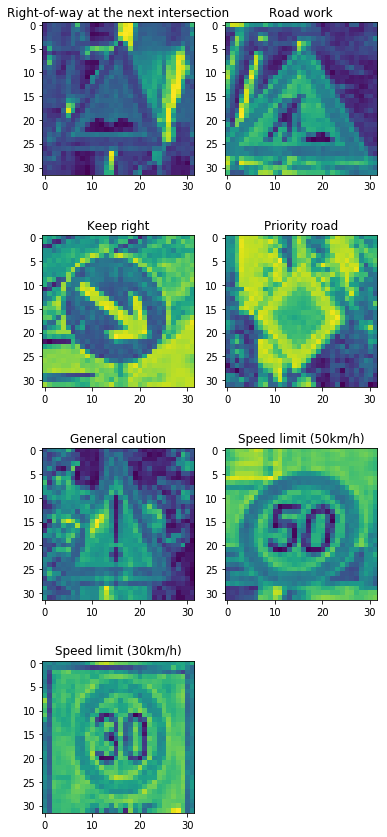

In [23]:
def show_trained_signs(signs, match):
    fig = plt.figure(figsize=(6, 15))
    plots = len(signs)
    for img in range(plots):  
        a=fig.add_subplot(np.ceil(plots/2), 2, img+1)
        image = signs[img].squeeze()
        plt.imshow(image)
        a.set_title(sign_dict[match[img]])
    plt.show()
    
with tf.Session() as sess:
    saver.restore(sess, './lenet') 
    result = sess.run(tf.argmax(logits, 1), feed_dict={x: X_custom})
    show_trained_signs(X_custom, result)

### Analyze Performance

In [24]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')    
    test_accuracy = evaluate(X_custom, y_custom)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

Test Accuracy = 85.7%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Five additional weaker matches were added to each sign title.

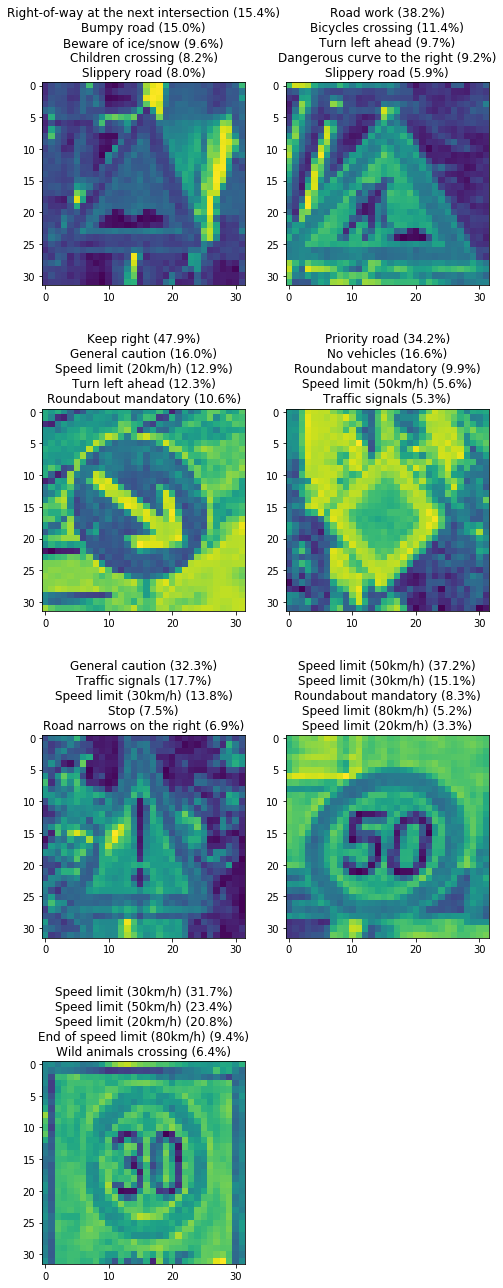

In [44]:
def show_softmax(signs, props, indices):
    fig = plt.figure(figsize=(8, 23))
    plots = len(signs)
    for img in range(plots):  
        a=fig.add_subplot(np.ceil(plots/2), 2, img+1)
        image = signs[img].squeeze()
        plt.imshow(image)
        a.set_title("{} ({:.1f}%)\n{} ({:.1f}%)\n{} ({:.1f}%)\n{} ({:.1f}%)\n{} ({:.1f}%)".format(sign_dict[indices[img][0]], props[img][0], \
                                                      sign_dict[indices[img][1]], props[img][1], \
                                                      sign_dict[indices[img][2]], props[img][2], \
                                                      sign_dict[indices[img][3]], props[img][3], \
                                                      sign_dict[indices[img][4]], props[img][4]))
    plt.show()    
    

with tf.Session() as sess:
    saver.restore(sess, './lenet') 
    props, indices = sess.run(tf.nn.top_k(logits, k=5), feed_dict={x: X_custom})
    show_softmax(X_custom, props, indices)

As far as designed model recognized 85% of the signs, the certainty in some cases is low. However, the difference between the top choice and the next one is quite satisfactory. In the first case, the sign is pretty distorted and leaned so the whole certainty is low (15.4%) and the next, correct result is 0.4% lower accurate. In the rest of the cases, the first prediction has twice more probability as the next one. The overall probability of the matched sign could be higher. Only in good quality image (as in Keep right sign) the model hash very high certainty (over 80%). 

The prediction speed limit (50 km/h) is pretty interesting. The sign is also distorted and askew (same as a Bumpy road), but the numbers on it are its characteristic attribute. Thanks to that the neural network recognizes it with almost 40% certainty.